In [1]:
import numpy as np
import pandas as pd
with open('household_power_consumption3.csv') as file:
    data_file = pd.read_csv(file)
    power_consumption = data_file.iloc[:,3]

In [2]:
windowed_data = []
# Format data into rolling window sequences
sequence_length = 10
prediction_steps = 5
for index in range(len(power_consumption) - sequence_length):  # for e.g: index=0 => 123, index=1 => 234 etc.
    windowed_data.append(power_consumption[index: index + sequence_length])
windowed_data = np.array(windowed_data)  # shape (number of samples, sequence length)

# Center data
data_mean = windowed_data.mean()
windowed_data -= data_mean
print('Center data so mean is zero (subtract each data point by mean of value: ', data_mean, ')')
print('Data  : ', windowed_data.shape)

# Split data into training and testing sets
train_set_ratio = 0.9
row = int(round(train_set_ratio * windowed_data.shape[0]))
train = windowed_data[:row, :]

Center data so mean is zero (subtract each data point by mean of value:  1.09623631439477 )
Data  :  (993986, 10)


In [3]:
x_train = train[:, :-prediction_steps]  # remove last prediction_steps from train set
y_train = train[:, -prediction_steps:]  # take last prediction_steps from train set
x_test = windowed_data[row:, :-prediction_steps]
y_test = windowed_data[row:, -prediction_steps:]  # take last prediction_steps from test set
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

result =  [x_train, y_train, x_test, y_test, data_mean]

## LSTM Model Setup

In [4]:
import time
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential, load_model

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
seed(1234)  # seed random numbers for Keras
from tensorflow import set_random_seed
set_random_seed(2)  # seed random numbers for Tensorflow backend

C:\Users\123\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def build_model(prediction_steps):
    model = Sequential()
    layers = [1, 75, 100, prediction_steps]
    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))  # add first layer
    model.add(Dropout(0.2))  # add dropout for first layer
    model.add(LSTM(layers[2], return_sequences=False))  # add second layer
    model.add(Dropout(0.2))  # add dropout for second layer
    model.add(Dense(layers[3]))  # add output layer
    model.add(Activation('linear'))  # output layer with linear activation
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print('Compilation Time : ', time.time() - start)
    return model

## LSTM Fit

In [6]:
global_start_time = time.time()
model = load_model('LSTM_power_consumption_model.h5')
sequence_length = 10
prediction_steps = 5
epochs = 50
model = build_model(prediction_steps)
model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.05)
predicted = model.predict(x_test)

Compilation Time :  0.06610751152038574
Train on 849857 samples, validate on 44730 samples
Epoch 1/50
849857/849857 [==============================] - 202s 238us/step - loss: 0.2068 - val_loss: 0.1863
Epoch 2/50
849857/849857 [==============================] - 199s 234us/step - loss: 0.1992 - val_loss: 0.1860
Epoch 3/50
849857/849857 [==============================] - 200s 235us/step - loss: 0.1977 - val_loss: 0.1809
Epoch 4/50
849857/849857 [==============================] - 198s 233us/step - loss: 0.1966 - val_loss: 0.1879
Epoch 5/50
849857/849857 [==============================] - 198s 233us/step - loss: 0.1957 - val_loss: 0.1794
Epoch 6/50
849857/849857 [==============================] - 198s 233us/step - loss: 0.1951 - val_loss: 0.1805
Epoch 7/50
849857/849857 [==============================] - 196s 230us/step - loss: 0.1947 - val_loss: 0.1803
Epoch 8/50
849857/849857 [==============================] - 200s 235us/step - loss: 0.1943 - val_loss: 0.1807
Epoch 9/50
849857/849857 [===

## Ploting Results

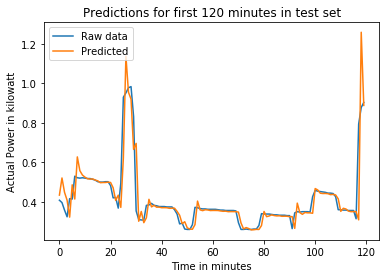

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.plot(y_test[:test_hours_to_plot * 60, 0] + result_mean, label='Raw data')  # plot actual test series
ax.plot(y_test[0:120, 0] + data_mean, label='Raw data')  # plot actual test series
ax.plot(predicted[0:120,0]+data_mean, label='Predicted')
plt.legend(loc='upper left')
plt.ylabel('Actual Power in kilowatt')
plt.xlabel('Time in minutes')
plt.title('Predictions for first {0} minutes in test set'.format(2 * 60))
plt.show()

In [23]:
error = y_test-predicted
np.mean(error*error)/np.mean(y_test+data_mean)

0.141956158126422